# Building a Currency Neutral Portfolio #

In [105]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.optimize import minimize

# Import Data
import yfinance as yf

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [106]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price', 'Adjusted_close']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"open",
        "High Price":"high",
        "Low Price":"low",
        "Close Price":"close",
        "Adjusted_close":"adjusted_close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2015-01-01":]

In [107]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [108]:
# First Call the Exchange Rate Index
data = yf.download('DX-Y.NYB', start='2015-01-01', end='2025-01-01', interval='1d', auto_adjust=True)
data.dropna(inplace=True)

# Close Price

dxy_data = data['Close']['DX-Y.NYB']
dxy_data

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02     91.080002
2015-01-05     91.379997
2015-01-06     91.500000
2015-01-07     91.889999
2015-01-08     92.370003
                 ...    
2024-12-24    108.260002
2024-12-26    108.129997
2024-12-27    108.000000
2024-12-30    108.129997
2024-12-31    108.489998
Name: DX-Y.NYB, Length: 2515, dtype: float64

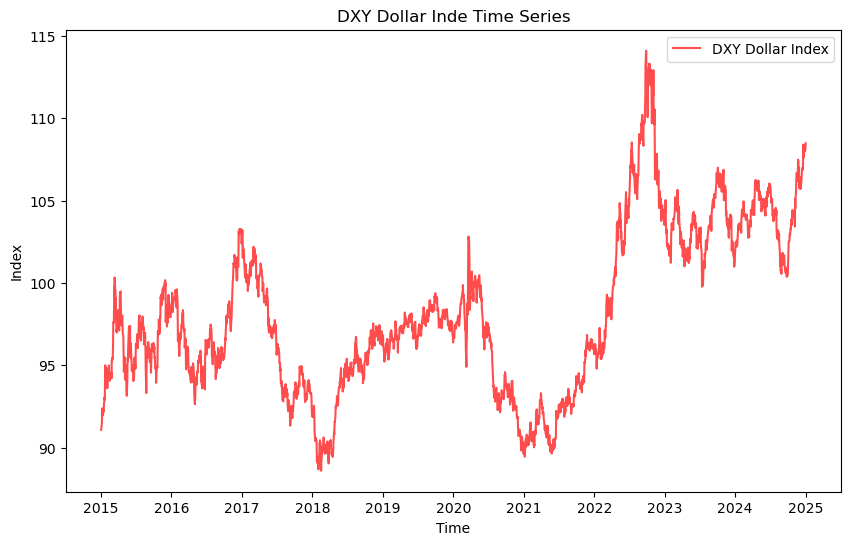

In [109]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(dxy_data, label='DXY Dollar Index', color='red', alpha=0.7)

# Config
plt.title('DXY Dollar Inde Time Series')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

# Show
plt.show()

In [110]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500
sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [111]:
# Create the Returns
benchmark_returns = sp500['sp_500'].pct_change(1).dropna()
dollar_returns = dxy_data.pct_change(1).dropna()
risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)

# Create the Excess Returns
benchmark_excess = benchmark_returns - risk_free_daily
dollar_excess = dollar_returns - risk_free_daily

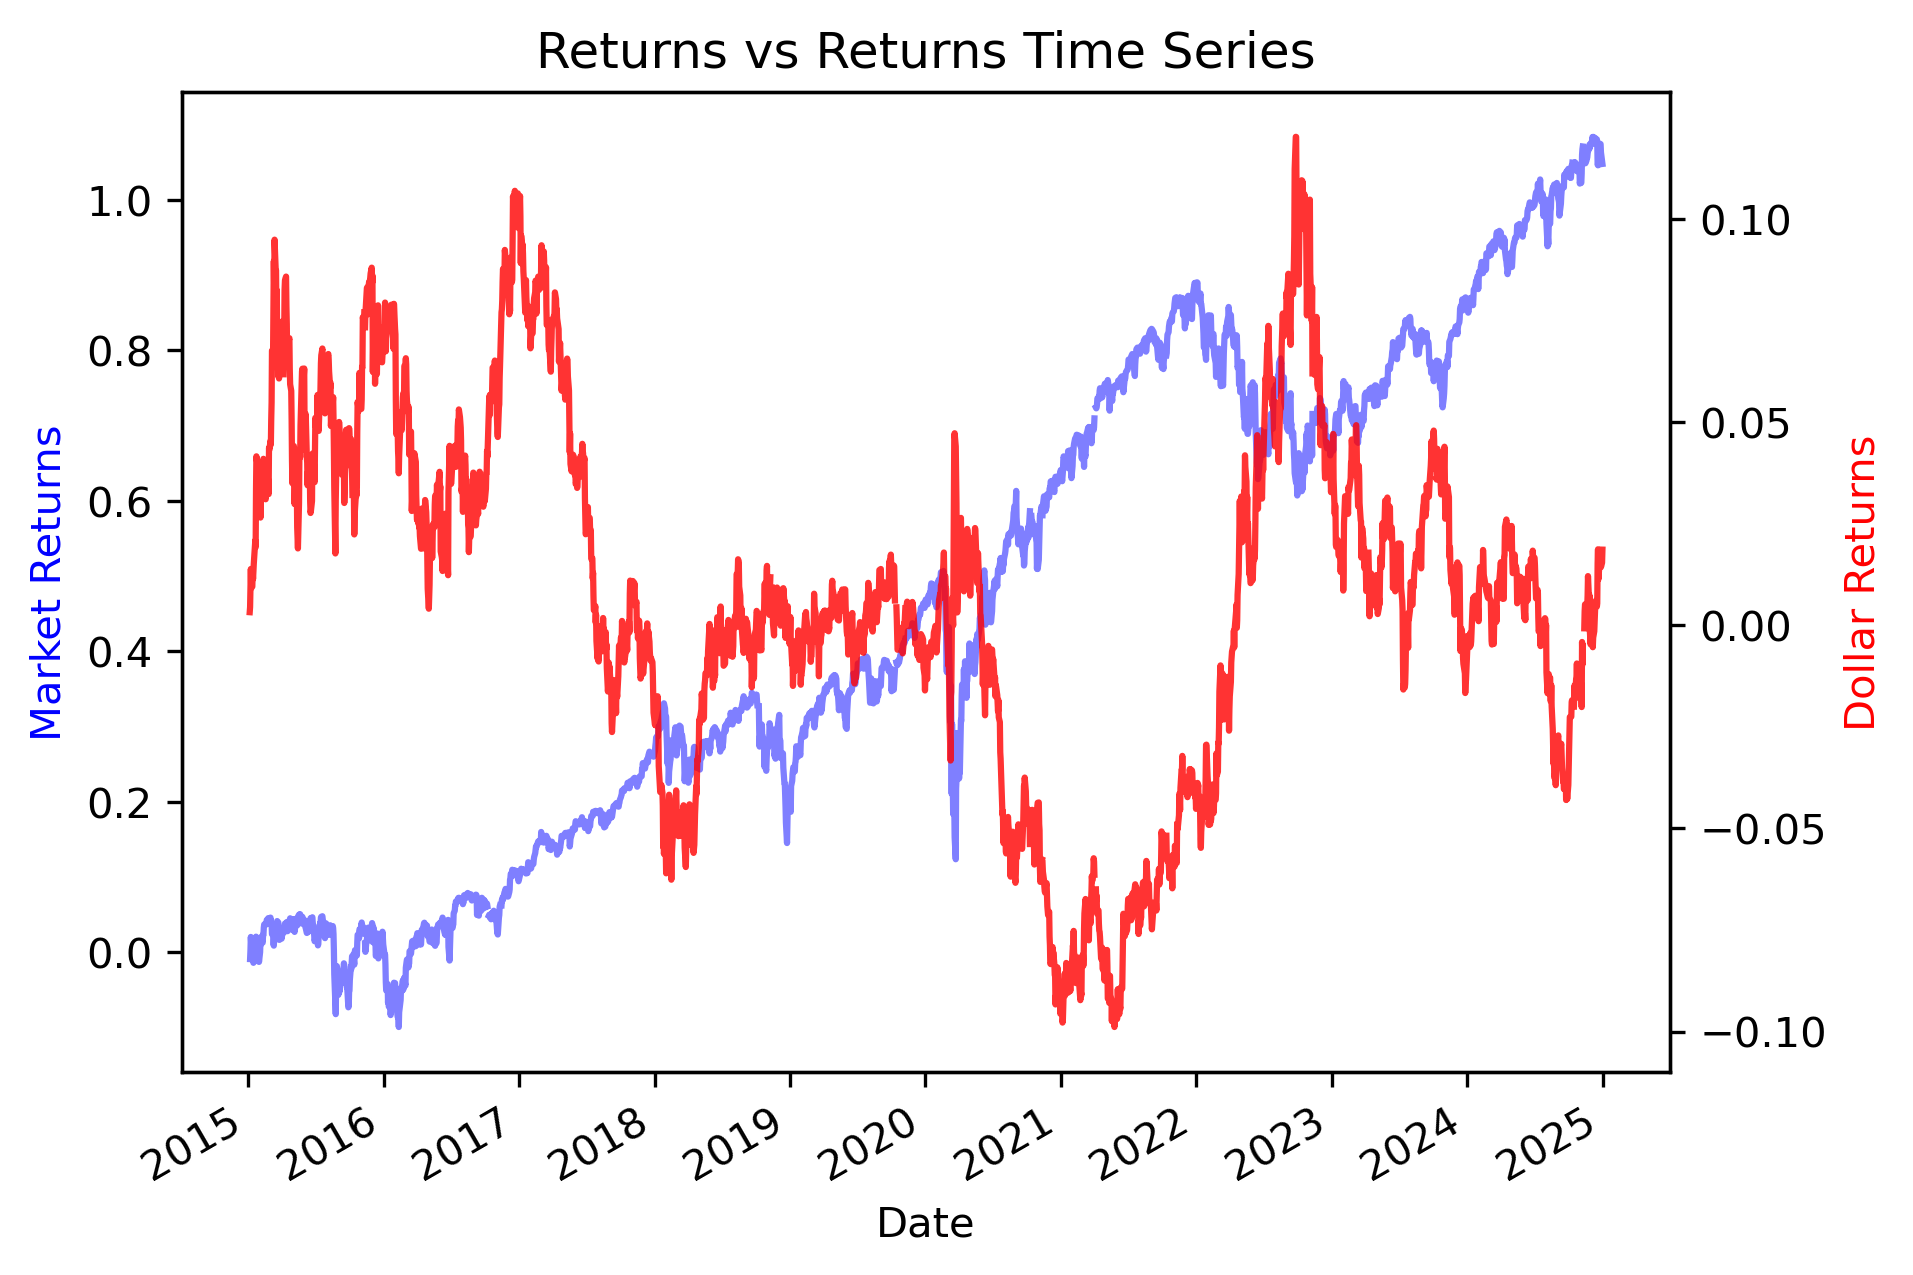

In [112]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
benchmark_excess.cumsum().plot(color = 'blue', ax = ax1, alpha=0.5, label = 'Market')
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Returns', 
    color='blue'
    )

# Dollar Returns Plot
ax2 = ax1.twinx()

dollar_excess.cumsum().plot(color = 'red', ax = ax2, alpha=0.8, label = 'Dollar Index')
ax2.set_ylabel(
    'Dollar Returns', 
    color='red'
    )

plt.title('Returns vs Returns Time Series')
plt.show()

In [113]:
# Market and Dollar Correlations

market_dollar_corr = dollar_excess.corr(benchmark_excess)

market_dollar_corr

-0.1088176533678984

In [114]:
# Import Data

# XOM Data
df_1 = import_financial_data('XOM')

# LMT Data
df_2 = import_financial_data('LMT')

# NOC Data
df_3 = import_financial_data('NOC')

# GS Data
df_4 = import_financial_data('GS')

# GD Data
df_5 = import_financial_data('GD')

In [115]:
# Let us find an unsensible portfolio to the market

data_portfolio = pd.DataFrame()

data_portfolio['XOM'] = df_1['adjusted_close']
data_portfolio['LMT'] = df_2['adjusted_close']
data_portfolio['NOC'] = df_3['adjusted_close']
data_portfolio['GS'] = df_4['adjusted_close']
data_portfolio['GD'] = df_5['adjusted_close']

data_portfolio = data_portfolio.dropna()

data_portfolio = data_portfolio.loc['2015-01-01':]

data_portfolio

,XOM,LMT,NOC,GS,GD
Date,,,,,
2015-01-02,92.83,193.31,146.46,194.41,138.45
2015-01-05,90.29,189.29,143.37,188.34,135.56
2015-01-06,89.81,188.40,144.16,184.53,135.72
2015-01-07,90.72,190.83,148.72,187.28,135.20
2015-01-08,92.23,195.13,152.17,190.27,138.46
...,...,...,...,...,...
2024-10-22,120.70,576.98,520.20,518.30,305.99
2024-10-23,120.27,571.10,516.40,517.20,304.40
2024-10-24,119.59,564.21,523.68,524.50,301.27


In [116]:
# Create the Returns

df_returns = data_portfolio.pct_change(1).dropna() 
df_returns = df_returns.subtract(risk_free_daily, axis=0)
df_returns.dropna(inplace = True)

df_returns

,XOM,LMT,NOC,GS,GD
Date,,,,,
2015-01-05,-0.027418,-0.020852,-0.021154,-0.031279,-0.020930
2015-01-06,-0.005370,-0.004756,0.005456,-0.020284,0.001126
2015-01-07,0.010079,0.012844,0.031578,0.014849,-0.003885
2015-01-08,0.016589,0.022477,0.023142,0.015910,0.024057
2015-01-09,-0.001464,-0.000618,0.003691,-0.015401,0.003629
...,...,...,...,...,...
2024-10-22,0.005049,-0.061340,-0.017956,0.000851,-0.006898
2024-10-23,-0.003678,-0.010306,-0.007420,-0.002238,-0.005312
2024-10-24,-0.005769,-0.012179,0.013983,0.014000,-0.010397


In [117]:
# Check correlations with dollar returns

df_returns['dollar_returns'] = dollar_excess
df_returns['market_returns'] = benchmark_excess

df_returns.corr()

,XOM,LMT,NOC,GS,GD,dollar_returns,market_returns
XOM,1.000000,0.394931,0.343381,0.528733,0.505313,-0.067430,0.550722
LMT,0.394931,1.000000,0.781045,0.369436,0.674224,0.018085,0.506262
NOC,0.343381,0.781045,1.000000,0.341823,0.651800,0.018285,0.463385
GS,0.528733,0.369436,0.341823,1.000000,0.560768,-0.067600,0.733730
GD,0.505313,0.674224,0.651800,0.560768,1.000000,-0.057862,0.650630
dollar_returns,-0.067430,0.018085,0.018285,-0.067600,-0.057862,1.000000,-0.110583
market_returns,0.550722,0.506262,0.463385,0.733730,0.650630,-0.110583,1.000000


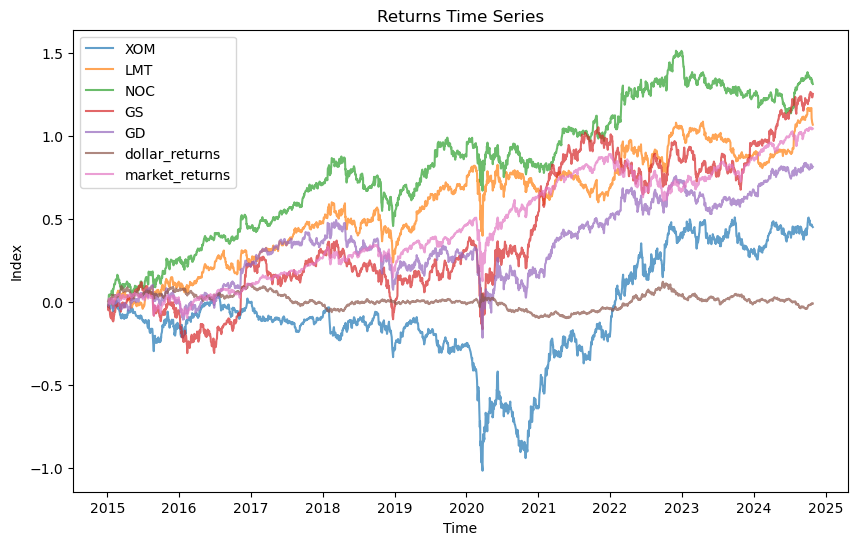

In [118]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

# Show
plt.show()

### Use CAPM Residuals ###

In [120]:
# Get the important data for the S&P500
capm_residuals = pd.read_csv(r"..\additional_data\capm_residuals.csv")
capm_residuals = capm_residuals.set_index('Date')
capm_residuals.index = pd.to_datetime(capm_residuals.index)
capm_residuals = capm_residuals[data_portfolio.columns]

# Add the Dollar Returns
capm_residuals['dollar_returns'] = dollar_excess

capm_residuals

,XOM,LMT,NOC,GS,GD,dollar_returns
Date,,,,,,
2015-01-06,0.001852,0.000294,0.010387,-0.010128,0.007878,0.001259
2015-01-07,0.000735,0.006311,0.025198,0.001710,-0.012621,0.004208
2015-01-08,0.002195,0.012412,0.013314,-0.004330,0.010600,0.005168
2015-01-09,0.005363,0.004156,0.008353,-0.005801,0.010012,-0.004710
2015-01-12,-0.012696,0.001725,-0.000604,-0.002976,-0.001605,0.000382
...,...,...,...,...,...,...
2024-10-22,0.005524,-0.061008,-0.017632,0.001520,-0.006454,0.000559
2024-10-23,0.003834,-0.005054,-0.002291,0.008325,0.001711,0.003247
2024-10-24,-0.007408,-0.013325,0.012864,0.011694,-0.011930,-0.003658


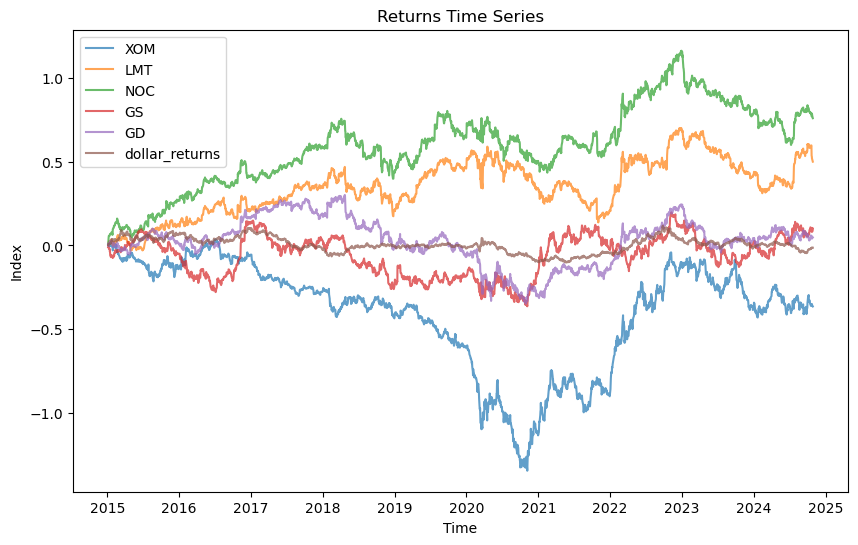

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(capm_residuals.cumsum(), label=capm_residuals.columns, alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

# Show
plt.show()

In [122]:
# Correlations

capm_residuals.corr()

,XOM,LMT,NOC,GS,GD,dollar_returns
XOM,1.000000,0.162543,0.120527,0.219979,0.232670,-0.012023
LMT,0.162543,1.000000,0.715726,-0.002702,0.527312,0.079962
NOC,0.120527,0.715726,1.000000,0.003794,0.521330,0.072590
GS,0.219979,-0.002702,0.003794,1.000000,0.161964,0.016928
GD,0.232670,0.527312,0.521330,0.161964,1.000000,0.013959
dollar_returns,-0.012023,0.079962,0.072590,0.016928,0.013959,1.000000


### Calculate the Betas ###

In [124]:
# Lets calculate the betas for the DXY

tickers = []
betas = []
lower_bounds = []
upper_bounds = []

# Calculate Weights
window = len(df_returns)
weights = window * wexp(window, window/2)

for stock in data_portfolio.columns:
    #Model specification
    model = sm.WLS(
        df_returns[stock], 
        sm.add_constant(df_returns[['market_returns', 'dollar_returns']]),
        missing='drop',
        weights=weights,
        )   
         
    #the results of the model
    results = model.fit()

    # Get the Parameters and CI
    params = results.params
    ci = results.conf_int(alpha=0.05)  # 95% CI
    
    tickers.append(stock)
    betas.append(params.iloc[2])
    lower_bounds.append(ci.iloc[2][0])  # First column: lower bound
    upper_bounds.append(ci.iloc[2][1])  # Second column: upper bound


In [125]:
# Example data: beta estimates and confidence intervals
betas_intervals = pd.DataFrame({
    'beta': betas,
    'ci_lower': lower_bounds,
    'ci_upper': upper_bounds,
}, index=tickers)

betas_intervals

,beta,ci_lower,ci_upper
XOM,0.016838,-0.130552,0.164228
LMT,0.257080,0.140312,0.373848
NOC,0.260093,0.130464,0.389722
GS,-0.030762,-0.148854,0.087330
GD,0.093437,-0.006804,0.193677


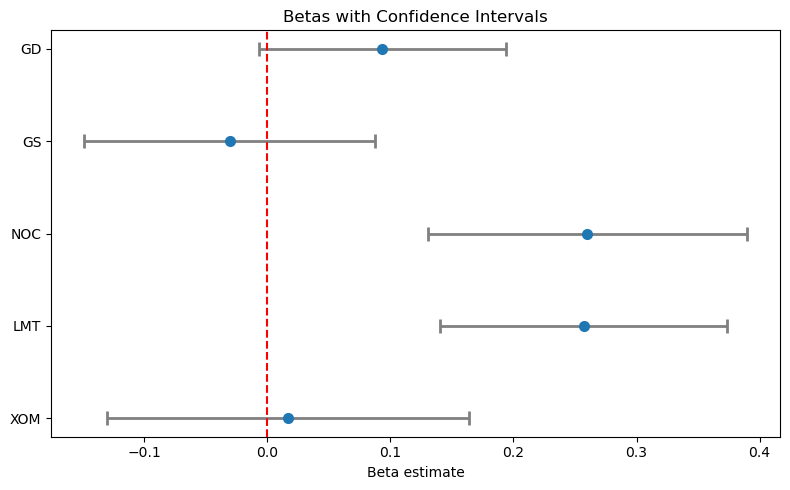

In [154]:
# Calculate symmetric errors for error bars
errors = [betas_intervals['beta'] - betas_intervals['ci_lower'], betas_intervals['ci_upper'] - betas_intervals['beta']]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(
    x=betas_intervals['beta'],                   # x-values (betas)
    y=range(len(betas_intervals)),               # y-positions
    xerr=errors,                      # confidence interval errors
    fmt='o',                          # circular markers for betas
    ecolor='gray',                    # color of the error bars
    capsize=5,                        # small caps on error bars
    elinewidth=2,                    # thickness of the error bars
    markeredgewidth=2                # thickness of the circle edge
)

# Customize the plot
ax.set_yticks(range(len(betas_intervals)))
ax.set_yticklabels(betas_intervals.index)
ax.axvline(0, color='red', linestyle='--')  # reference line
ax.set_xlabel('Beta estimate')
ax.set_title('Betas with Confidence Intervals')

plt.tight_layout()
plt.show()


In [127]:
# Define the Function
def dxy_betas(
    stock_excess,
    benchmark_excess = benchmark_excess,
    dollar_excess = dollar_excess,
):
    # Common Index
    common_index = stock_excess.index.intersection(benchmark_excess.index).intersection(dollar_excess.index)
    common_index = sorted(common_index)

    # Reindex
    stock_excess = stock_excess.loc[common_index]
    benchmark_excess = benchmark_excess.loc[common_index]
    dollar_excess = dollar_excess.loc[common_index]
    
    # Create the data
    y = stock_excess
    x = pd.concat([benchmark_excess, dollar_excess], axis=1)
    
    # Rolling window
    window = 252
    weights = wexp(window, window/2)
    
    betas = []
    index = []
    
    for i in range(window, len(y)):
        Y_window = y.iloc[i - window:i]
        X_window = x.iloc[i - window:i]
        
        X_window = sm.add_constant(X_window)
        
        model = sm.WLS(Y_window, X_window, missing='drop', weights=weights).fit()
        
        betas.append(model.params.values)
        index.append(y.index[i])

    parameters_df = pd.DataFrame(betas, columns=["const", "capm_betas", "dxy_betas"], index=index)

    return parameters_df

In [128]:
# Get the betas
dxy_betas_df = pd.DataFrame()

# Define the loop
for stock in data_portfolio.columns:
    df = dxy_betas(df_returns[stock])

    dxy_betas_df[stock] = df['dxy_betas']

# See betas
dxy_betas_df

,XOM,LMT,NOC,GS,GD
2016-01-07,-0.154238,0.165981,0.186469,0.284705,0.035589
2016-01-08,-0.166895,0.167602,0.170438,0.283624,0.052188
2016-01-11,-0.175680,0.172919,0.166206,0.293677,0.056402
2016-01-12,-0.180179,0.175915,0.166729,0.296992,0.060899
2016-01-13,-0.177151,0.176066,0.165129,0.295691,0.060336
...,...,...,...,...,...
2024-10-22,-0.022831,0.111422,-0.047749,-0.377651,0.185953
2024-10-23,-0.019914,0.091128,-0.056231,-0.378734,0.181299
2024-10-24,-0.027364,0.066819,-0.072375,-0.362400,0.176132
2024-10-25,-0.027404,0.097411,-0.111574,-0.387059,0.193897


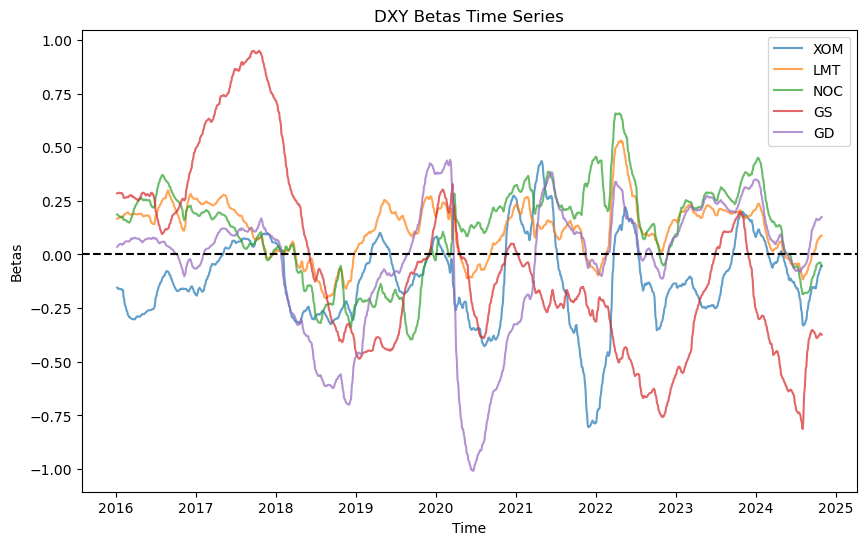

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(dxy_betas_df.ewm(span=21, adjust = False).mean(), label=dxy_betas_df.columns, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('DXY Betas Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

### Portfolio Optimization ###

In [258]:
# Let us Calculate the Weights
def rolling_weights(
    returns, 
    betas, 
    window=252, 
    rebalance_freq=63
):
    # Common Index
    common_index = returns.index.intersection(betas.index)  # Common Date
    returns = returns.reindex(common_index)
    betas = betas.reindex(common_index)

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i-window:i]  # Rolling Window
        past_betas = betas.iloc[i-window:i]
        
        # Mean and Covariance
        beta = past_betas.mean()
        Sigma = past_returns.cov()

        # Inverse
        lambda_ = 1e-6  # Tikhonov Regularization
        Sigma_inv = np.linalg.inv(Sigma + lambda_ * np.eye(Sigma.shape[0]))
        
        # Sigma_inv = np.linalg.inv(Sigma)

        # Ones
        iota = np.ones(len(beta))

        # And now obtain the coefficients
        C = np.dot(np.dot(iota.T, Sigma_inv), iota)
        D = np.dot(np.dot(beta.T, Sigma_inv), beta)
        E = np.dot(np.dot(beta.T, Sigma_inv), iota)
        Delta = (D*C - E*E)
        
        w = ((D/Delta)*(Sigma_inv @ iota)) - ((E/Delta)*(Sigma_inv @ beta))

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [260]:
# Obtain the Weights

cnp_weights = rolling_weights(df_returns[dxy_betas_df.columns], dxy_betas_df)

cnp_weights

,XOM,LMT,NOC,GS,GD
2017-01-10,0.413216,0.195066,0.242452,-0.085388,0.234655
2017-01-11,0.413216,0.195066,0.242452,-0.085388,0.234655
2017-01-12,0.413216,0.195066,0.242452,-0.085388,0.234655
2017-01-13,0.413216,0.195066,0.242452,-0.085388,0.234655
2017-01-17,0.413216,0.195066,0.242452,-0.085388,0.234655
...,...,...,...,...,...
2024-10-22,0.147577,0.270666,0.125129,0.253687,0.202941
2024-10-23,0.147577,0.270666,0.125129,0.253687,0.202941
2024-10-24,0.147577,0.270666,0.125129,0.253687,0.202941
2024-10-25,0.147577,0.270666,0.125129,0.253687,0.202941


In [262]:
# Calculate the ZBP

cnp_returns = ((df_returns[dxy_betas_df.columns] * cnp_weights).dropna()).sum(axis = 1)
cnp_returns.name = 'CNP'

cnp_returns

2017-01-10   -0.008853
2017-01-11    0.001574
2017-01-12   -0.006796
2017-01-13    0.004196
2017-01-17    0.003134
                ...   
2024-10-22   -0.019288
2024-10-23   -0.005906
2024-10-24   -0.000956
2024-10-25   -0.007108
2024-10-28    0.000366
Name: CNP, Length: 1950, dtype: float64

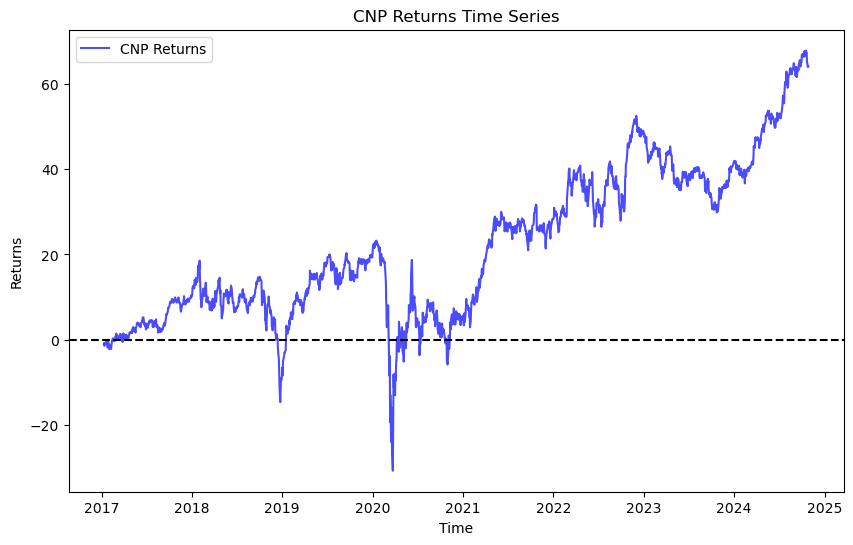

In [264]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(cnp_returns.mul(100).cumsum(), label='CNP Returns', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('CNP Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

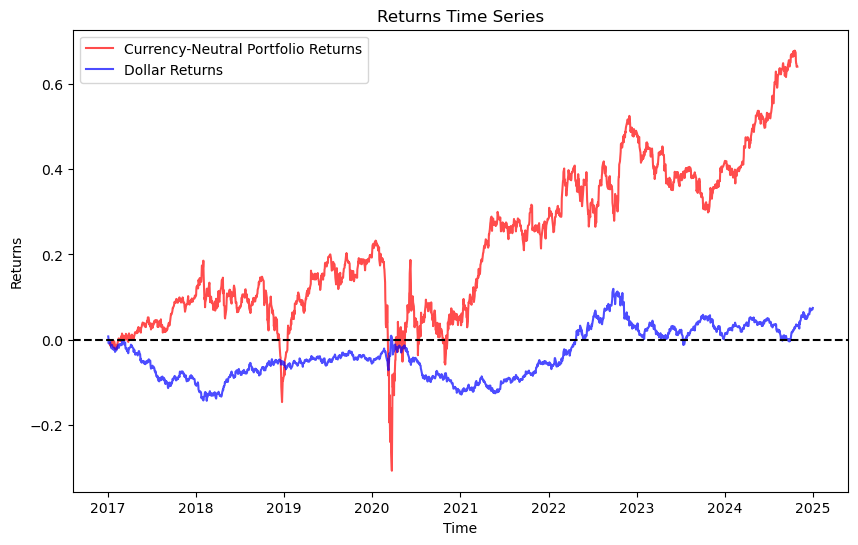

In [266]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(cnp_returns.cumsum(), label='Currency-Neutral Portfolio Returns', color='red', alpha=0.7)
plt.plot(dollar_returns.loc['2017':].cumsum(), label='Dollar Returns', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [268]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [270]:
# Check the Analytics

df_analytics = df_returns[dxy_betas_df.columns].copy()
df_analytics['CNP_Port'] = cnp_returns

df_analytics.dropna(inplace=True)

df_analytics

,XOM,LMT,NOC,GS,GD,CNP_Port
Date,,,,,,
2017-01-10,-0.012818,-0.006427,-0.011515,-0.001383,0.001582,-0.008853
2017-01-11,0.010176,-0.004125,-0.006757,0.013086,0.003961,0.001574
2017-01-12,-0.005479,-0.009903,-0.010430,-0.007877,-0.003171,-0.006796
2017-01-13,0.000050,0.007495,0.004385,0.001821,0.007695,0.004196
2017-01-17,0.011633,-0.001675,-0.007406,-0.035103,-0.010857,0.003134
...,...,...,...,...,...,...
2024-10-22,0.005049,-0.061340,-0.017956,0.000851,-0.006898,-0.019288
2024-10-23,-0.003678,-0.010306,-0.007420,-0.002238,-0.005312,-0.005906
2024-10-24,-0.005769,-0.012179,0.013983,0.014000,-0.010397,-0.000956


In [272]:
# And the Table

analytics_table = calculate_analytics(df_analytics)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
XOM,0.063663,0.296377,0.214805,-0.009800,-0.028237
LMT,0.102560,0.232962,0.440244,-0.004213,-0.019791
NOC,0.110271,0.251334,0.438741,-0.004183,-0.022429
GS,0.132051,0.295558,0.446784,-0.005539,-0.026300
GD,0.075112,0.228574,0.328611,-0.007073,-0.022118
CNP_Port,0.082652,0.204020,0.405119,-0.005376,-0.018623


In [274]:
# Correlation with the DXY

dollar_returns.corr(cnp_returns)

-0.09611362207715202